# Redes neuronales hibridas  para clasificación multiple


In [1]:
# Install the relevant packages.
#%pip install --upgrade pip
#%pip install torch torchvision torchaudio
#%pip install cudaq -> ya viene instalado en el braket de AWS

In [2]:
# Check installed clasico
import sys
import numpy as np
import matplotlib
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")

import torch, torchvision, torchaudio
print("torch:", torch.__version__)
print("vision:", torchvision.__version__)
print("audio:", torchaudio.__version__)

Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
NumPy version: 1.26.4
Matplotlib version: 3.10.7
torch: 2.9.1+cu128
vision: 0.24.1+cu128
audio: 2.9.1+cu128


In [3]:

import cudaq
print(f"CUDAQ version: {cudaq.__version__}")
print(f"Running on target: {cudaq.get_target().name}")

CUDAQ version: CUDA-Q Version 0.12.0 (https://github.com/NVIDIA/cuda-quantum 6adf92bcda4df7465e4fe82f1c8f782ae69d8bd2)
Running on target: qpp-cpu


In [4]:
import sys
import cudaq

print(f"Running on target {cudaq.get_target().name}")
qubit_count = 2


@cudaq.kernel
def kernel():
    qubits = cudaq.qvector(qubit_count)
    h(qubits[0])
    for i in range(1, qubit_count):
        x.ctrl(qubits[0], qubits[i])
    mz(qubits)


result = cudaq.sample(kernel)
print(result)  # Example: { 11:500 00:500 }

Running on target qpp-cpu
{ 00:490 11:510 }



In [5]:
# importar las librerías necesarias
import cudaq
from cudaq import spin

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Para asegurar que los resultados sean reproducibles
torch.manual_seed(42)

cudaq.set_random_seed(44)

In [6]:
# Configurar el dispositivo
# Set CUDAQ and PyTorch to run on either CPU or GPU.

device = torch.device('cpu')
cudaq.set_target("qpp-cpu")

#cudaq.set_target("nvidia")
#device = torch.device("cuda:0")

## Descripción del Conjunto de Datos MNIST

- *¿Qué es?:* MNIST (Modified National Institute of Standards and Technology database) es una gran base de datos de dígitos escritos a mano, del 0 al 9.
- *Contenido:* Contiene 70,000 imágenes en escala de grises.
- *Conjunto de entrenamiento:* 60,000 imágenes.
- *Conjunto de prueba:* 10,000 imágenes.
- *Formato de imagen:* Cada imagen tiene un tamaño de 28x28 píxeles.
- *Uso común:* Es considerado el "Hola, Mundo" de la visión por computadora y el aprendizaje profundo. Se utiliza para entrenar y probar algoritmos de clasificación de imágenes.


Paso 2: Cargar, Transformar y Previsualizar los Datos
torchvision nos facilita la descarga y preparación de datasets.

Transformaciones: Convertimos las imágenes a tensores de PyTorch y las normalizamos. La normalización (ajustar los valores de los píxeles para que tengan una media de 0.5 y una desviación estándar de 0.5) ayuda a que el modelo entrene más rápido y de forma más estable.
Descarga: Descargamos los conjuntos de entrenamiento y prueba. FashionMNIST ya viene separado en train y test.

In [7]:
# 1. Definir las transformaciones para las imágenes
# - transforms.ToTensor() convierte la imagen (PIL) a un Tensor de PyTorch.
# - transforms.Normalize() ajusta los valores del tensor para que tengan una media y desviación estándar específicas.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Media y Desviación Estándar para un solo canal (escala de grises)
])

# 2. Descargar los datasets de entrenamiento y prueba
train_full_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

print(f"Tamaño total del dataset de entrenamiento: {len(train_full_dataset)}")
print(f"Tamaño del dataset de prueba: {len(test_dataset)}")


Tamaño total del dataset de entrenamiento: 60000
Tamaño del dataset de prueba: 10000


In [8]:
# --- MODIFICACIÓN: Usar solo 1000 muestras para una prueba rápida ---
from torch.utils.data import Subset

# 1. Creamos un subconjunto con las primeras 1000 imágenes del dataset de entrenamiento completo
n_samples_prueba = 1000
train_subset_for_testing = Subset(train_full_dataset, range(n_samples_prueba))

# 2. Ahora, basamos la división 80/20 en este subconjunto de 1000 muestras
train_size = int(0.8 * len(train_subset_for_testing)) # 80% de 1000 = 800
val_size = len(train_subset_for_testing) - train_size # 20% de 1000 = 200

# Dividimos el dataset de entrenamiento
train_dataset, val_dataset = random_split(train_subset_for_testing, [train_size, val_size])

print(f"Tamaño del subconjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del subconjunto de validación: {len(val_dataset)}")

# Crear los DataLoaders
# Los DataLoaders nos permiten iterar sobre los datos en lotes (batches)
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Tamaño del subconjunto de entrenamiento: 800
Tamaño del subconjunto de validación: 200


--- Previsualización de Datos (MNIST) ---


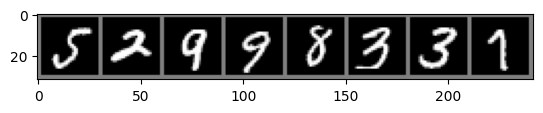

Etiquetas:  5     2     9     9     8     3     3     7    


In [9]:
# Clases de MNIST (dígitos del 0 al 9)
classes = tuple(str(i) for i in range(10))

# Función para mostrar imágenes (sin cambios)
def imshow(img):
    img = img / 2 + 0.5  # Des-normalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtener un lote de imágenes de entrenamiento
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostrar las primeras 8 imágenes y sus etiquetas
print("--- Previsualización de Datos (MNIST) ---")
imshow(torchvision.utils.make_grid(images[:8]))
print('Etiquetas: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Bloque convolucional para extracción de características
        self.conv_stack = nn.Sequential(
            # Entrada: 1x28x28 -> Salida: 32x26x26
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            # Entrada: 32x26x26 -> Salida: 32x13x13
            nn.MaxPool2d(kernel_size=2),
            # Entrada: 32x13x13 -> Salida: 64x11x11
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            # Entrada: 64x11x11 -> Salida: 64x5x5
            nn.MaxPool2d(kernel_size=2)
        )
        # Aplanador y clasificador
        self.flatten = nn.Flatten()
        self.fc_stack = nn.Sequential(
            # Previene el sobreajuste
            nn.Dropout(0.5),
            # Mapea las características a las 10 clases de salida
            # La entrada es 64*5*5 = 1600
            nn.Linear(64 * 5 * 5, 10)
        )

    def forward(self, x):
        # Pasa la imagen por las capas convolucionales
        x = self.conv_stack(x)
        # Aplana el resultado para la capa densa
        x = self.flatten(x)
        # Pasa por el clasificador final
        logits = self.fc_stack(x)
        return logits

# Instanciamos el modelo y lo movemos al dispositivo (GPU/CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)
print("\n--- Arquitectura del Modelo ---")
print(model)



--- Arquitectura del Modelo ---
CNN(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_stack): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1600, out_features=10, bias=True)
  )
)


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Pérdida (loss): {loss:>7f}  [{current:>5d}/{size:>5d}]")

def validation_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Resultado: \n Precisión (Accuracy): {(100*correct):>0.1f}%, Pérdida promedio: {val_loss:>8f} \n")

# Bucle principal de entrenamiento
epochs = 10
print("\n--- Iniciando Entrenamiento con MNIST ---")
for t in range(epochs):
    print(f"Época {t+1}\n-------------------------------")
    print("Entrenando...")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validando...")
    validation_loop(val_loader, model, loss_fn)
print("¡Entrenamiento finalizado!")



--- Iniciando Entrenamiento con MNIST ---
Época 1
-------------------------------
Entrenando...
Pérdida (loss): 2.326925  [   64/  800]
Validando...
Resultado: 
 Precisión (Accuracy): 73.5%, Pérdida promedio: 1.637920 

Época 2
-------------------------------
Entrenando...
Pérdida (loss): 1.636946  [   64/  800]
Validando...
Resultado: 
 Precisión (Accuracy): 83.0%, Pérdida promedio: 0.860735 

Época 3
-------------------------------
Entrenando...
Pérdida (loss): 0.589803  [   64/  800]
Validando...
Resultado: 
 Precisión (Accuracy): 85.5%, Pérdida promedio: 0.667567 

Época 4
-------------------------------
Entrenando...
Pérdida (loss): 0.433944  [   64/  800]
Validando...
Resultado: 
 Precisión (Accuracy): 88.0%, Pérdida promedio: 0.574240 

Época 5
-------------------------------
Entrenando...
Pérdida (loss): 0.403675  [   64/  800]
Validando...
Resultado: 
 Precisión (Accuracy): 89.0%, Pérdida promedio: 0.524867 

Época 6
-------------------------------
Entrenando...
Pérdida (loss

In [13]:
print("\n--- Evaluando con el conjunto de Prueba (Test) ---")
validation_loop(test_loader, model, loss_fn)



--- Evaluando con el conjunto de Prueba (Test) ---
Resultado: 
 Precisión (Accuracy): 92.4%, Pérdida promedio: 0.245266 



In [14]:
# --- Guardar los pesos del modelo entrenado ---

def save_model(model, name):
    # Define el nombre del archivo donde se guardarán los pesos.
    RUTA_MODELO = f"{name}.pth"
    # Usamos model.state_dict() para obtener solo los parámetros aprendibles.
    torch.save(model.state_dict(), RUTA_MODELO)
    print(f"¡Modelo guardado exitosamente en {RUTA_MODELO}!")

save_model(model, "cnn_mnist_weights")

¡Modelo guardado exitosamente en cnn_mnist_weights.pth!


## Implementación del Modelo Híbrido Cuántico-Clásico

Ahora, construiremos y entrenaremos el modelo híbrido. Este modelo combinará capas convolucionales clásicas para la extracción de características con un circuito cuántico parametrizado para el procesamiento de la información.

In [26]:
# DEFINIR EL KERNEL DE FORMA GLOBAL (FUERA DE LA CLASE)
def create_quantum_kernel(n_qubits: int):
    """Factory para crear kernels cuánticos"""
    @cudaq.kernel
    def quantum_kernel(features: list[float]) -> None:  # ✅ Anotación correcta
        """
        Kernel cuántico parametrizado
        
        Args:
            features: Lista de características (ángulos)
        """
        qubits = cudaq.qvector(n_qubits)
        
        # Codificación de características con rotaciones RY
        for i in range(len(features)):
            ry(features[i] * 3.14159, qubits[i])
        
        # Entrelazamiento con compuertas CNOT
        for i in range(n_qubits - 1):
            cx(qubits[i], qubits[i + 1])
    
    return quantum_kernel


class QuantumFunction(torch.autograd.Function):
    """Función personalizada de autograd para ejecutar circuitos cuánticos"""
    
    @staticmethod
    def forward(ctx, x, kernel, hamiltonian, n_features, n_outputs_quantum):
        """
        Ejecuta el circuito cuántico para cada muestra del batch
        
        Args:
            x: Tensor de forma (batch_size, n_features)
        """
        ctx.save_for_backward(x)
        ctx.kernel = kernel
        ctx.hamiltonian = hamiltonian
        ctx.n_features = n_features
        ctx.n_outputs_quantum = n_outputs_quantum
        
        batch_exp_vals = []
        
        # Procesar cada muestra del batch por separado
        for i in range(x.shape[0]):
            # ✅ CORRECTO: Convertir a lista de floats
            # x[i] tiene forma (n_features,) después de detach()
            single_input = x[i].detach().cpu().numpy()  # Numpy array
            single_input_list = single_input.tolist()   # Convertir a lista Python
            
            # Verificar que es una lista
            print(f"Muestra {i}: tipo={type(single_input_list)}, valor={single_input_list[:3]}...")
            
            try:
                # Ejecutar el circuito cuántico
                result = cudaq.observe(kernel, hamiltonian, single_input_list)
                
                # Extraer valores de expectación
                exp_vals = result.get_expectation_values()
                batch_exp_vals.append(float(exp_vals[0]))
                
            except Exception as e:
                print(f"Error procesando muestra {i}: {e}")
                raise
        
        output = torch.tensor(batch_exp_vals, 
                            dtype=x.dtype, 
                            device=x.device)
        return output.unsqueeze(1)  # Asegurar forma correcta: (batch_size, 1)

    @staticmethod
    def backward(ctx, grad_output):
        """Gradiente numérico aproximado"""
        return None, None, None, None, None


class QuantumLayer(nn.Module):
    """Capa que encapsula la función cuántica"""
    
    def __init__(self, n_features: int, n_outputs_quantum: int):
        super(QuantumLayer, self).__init__()
        self.n_features = n_features
        self.n_outputs_quantum = n_outputs_quantum
        
        # Obtener el kernel usando la factory function
        self.kernel = create_quantum_kernel(n_features)
        
        # Definir el Hamiltoniano (observable)
        self.hamiltonian = sum(spin.z(i) for i in range(n_features))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Ejecuta el circuito cuántico para cada muestra
        
        Args:
            x: Tensor de entrada con forma (batch_size, n_features)
            
        Returns:
            Tensor de valores de expectación con forma (batch_size, 1)
        """
        return QuantumFunction.apply(x, self.kernel, self.hamiltonian, 
                                     self.n_features, self.n_outputs_quantum)

class HybridCNN(nn.Module):
    """Red Neuronal Híbrida: CNN Clásica + Capa Cuántica"""
    def __init__(self, n_qubits: int = 4):
        super(HybridCNN, self).__init__()
        
        # Parte clásica: Convoluciones
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Aplanador
        self.flatten = nn.Flatten()
        
        # Capa densa antes de lo cuántico
        self.pre_quantum_fc = nn.Linear(64 * 5 * 5, n_qubits)
        
        # Capa cuántica
        self.quantum_layer = QuantumLayer(n_features=n_qubits, 
                                         n_outputs_quantum=n_qubits)
        
        # Capa densa después de lo cuántico
        self.post_quantum_fc = nn.Linear(n_qubits, 10)
    
    def forward(self, x):
        # Características clásicas
        x = self.conv_stack(x)
        x = self.flatten(x)
        
        # Reducción a características cuánticas
        x = self.pre_quantum_fc(x)
        x = torch.sigmoid(x)  # Normalizar entrada cuántica
        
        # Procesamiento cuántico
        x = self.quantum_layer(x)
        
        # Clasificación final
        logits = self.post_quantum_fc(x)
        return logits


# Crear instancia del modelo híbrido
hybrid_model = HybridCNN(n_qubits=4).to(device)
print("\n--- Arquitectura del Modelo Híbrido ---")
print(hybrid_model)


--- Arquitectura del Modelo Híbrido ---
HybridCNN(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (pre_quantum_fc): Linear(in_features=1600, out_features=4, bias=True)
  (quantum_layer): QuantumLayer()
  (post_quantum_fc): Linear(in_features=4, out_features=10, bias=True)
)


In [27]:
# Test de validación
test_input = torch.randn(2, 1, 28, 28).to(device)
print(f"Input shape: {test_input.shape}")

try:
    output = hybrid_model(test_input)
    print(f"Output shape: {output.shape}")
    print("✅ Modelo híbrido funciona correctamente!")
    print(f"Output logits:\n{output}")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Input shape: torch.Size([2, 1, 28, 28])
Muestra 0: tipo=<class 'list'>, valor=[0.47200697660446167, 0.47281649708747864, 0.4795275330543518]...
Error procesando muestra 0: error: Invalid runtime argument type. Argument of type <class 'float'> was provided, but list[float] was expected.

Offending code:
  File "/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,

❌ Error: error: Invalid runtime argument type. Argument of type <class 'float'> was provided, but list[float] was expected.

Offending code:
  File "/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,



RuntimeError: error: Invalid runtime argument type. Argument of type <class 'float'> was provided, but list[float] was expected.

Offending code:
  File "/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,



### Entrenamiento del Modelo Híbrido

Ahora, entrenaremos el modelo híbrido usando el mismo bucle de entrenamiento que para el modelo clásico. Notarás que el entrenamiento puede ser más lento debido a la simulación de los circuitos cuánticos.

In [22]:
# Definir la función de pérdida y el optimizador para el modelo híbrido
loss_fn_hybrid = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=1e-3)

# Bucle principal de entrenamiento para el modelo híbrido
epochs = 10
print("\n--- Iniciando Entrenamiento del Modelo Híbrido con MNIST ---")
for t in range(epochs):
    print(f"Época {t+1}\n-------------------------------")
    print("Entrenando (Híbrido)...")
    train_loop(train_loader, hybrid_model, loss_fn_hybrid, optimizer_hybrid)
    print("Validando (Híbrido)...")
    validation_loop(val_loader, hybrid_model, loss_fn_hybrid)
print("¡Entrenamiento híbrido finalizado!")

# Evaluar el modelo híbrido en el conjunto de prueba
print("\n--- Evaluando Modelo Híbrido con el conjunto de Prueba (Test) ---")
validation_loop(test_loader, hybrid_model, loss_fn_hybrid)

# Guardar los pesos del modelo híbrido entrenado
save_model(hybrid_model, "hybrid_cnn_mnist_weights")


--- Iniciando Entrenamiento del Modelo Híbrido con MNIST ---
Época 1
-------------------------------
Entrenando (Híbrido)...
Error procesando muestra 0: 2151397300.py:5: error: list argument annotation must provide element type, e.g. list[float] instead of list.
	 (offending source -> list)


CompilerError: 2151397300.py:5: [91merror: [0m[1mlist argument annotation must provide element type, e.g. list[float] instead of list.
	 (offending source -> list)[0m